# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [13]:
# import some other packages to be used
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import cv2 
from keras.applications.resnet50 import preprocess_input, decode_predictions

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [14]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 3


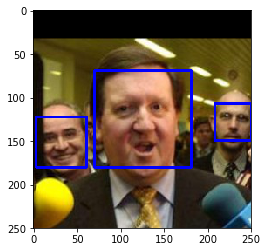

In [15]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [16]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

*__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.*
- *What percentage of the first 100 images in `human_files` have a detected human face?*
- *What percentage of the first 100 images in `dog_files` have a detected human face? *

*Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.*

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
for s_org, l_col in zip(['human', 'dog'], [human_files_short, dog_files_short]):
    print('detected faces in {} images: {}%'.format(s_org, sum([face_detector(x) for x in l_col])))

detected faces in human images: 99%
detected faces in dog images: 11%


*__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?*

__Answer:__
Even presenting such limitation, we still would risk having frustrated users. A "clear view of a face" to our algorithm might be very different from what is clear from a human point of view. So, would be better to detect faces in a probabilistic fashion, using some model, as a deep learning network.

Below, I built a Deep Neural Network to provide answers in that way. I used two convolutional layers, each one followed by a max pooling layer to reduce its dimensionality. I also added to the convolutional layers a RELU activation function. After those layers, I included global average pooling layer to help gather the best features and flatten the data. Then, I included two fully connected (dense) layers and a dropout layer between them to contribute to prevent overfitting. Finally, I added a softmax activation to the output layer, the last one.

As I one-hot encoded each class of the instances from the dataset (humans or dogs), the deep neural network returns the probability of a given a sample be a human or a dog. I trained the model using 1000 images (500 humans and 500 dogs) and run only 200 epochs. The test took about 2 minutes and yielded an accuracy of 88% to detect if it is a human and 92% to identify if it is a dog.

The performance of the model in the test set was not bad. However, the plots related to the validation set suggested that the model stop improving around the 50th epoch. Still, this model could be used to classify images without a clearly presented face.

```
Udacity:

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.
```

In [56]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

def load_resized(img_path):
    img = cv2.imread(img_path)
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.resize(img, (32, 32))

humans_X = [load_resized(i) for i in human_files]
dogs_X = [load_resized(i) for i in train_files]

In [61]:
# Flatten the data passed to be used in Keras
def make_y(X, y_row):
    return np.array([list(y_row) for x in X], dtype=np.float32)

def make_x_y(i_init, i_end):
    h_X_short = humans_X[i_init:i_end]
    d_X_short = dogs_X[i_init:i_end]

    # one hot encode
    h_y = make_y(h_X_short, [1, 0])
    d_y = make_y(d_X_short, [0, 1])

    x = np.concatenate((h_X_short, d_X_short), axis=0)
    y = np.concatenate((h_y, d_y), axis=0)
    return x, y

In [62]:
# create the train, validation and test set
x_train, y_train = make_x_y(100, 600)
x_valid, y_valid = make_x_y(600, 700)
x_test, y_test = make_x_y(0, 100)

In [63]:
# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (1000, 32, 32, 3)
1000 train samples
200 test samples
200 validation samples


In [64]:
# specify the model architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               3960      
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
__________

In [65]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [66]:
# train the model
from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=0, 
                               save_best_only=True)
%time hist = model.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_valid, y_valid),\
                       callbacks=[checkpointer], verbose=0, shuffle=True)

CPU times: user 5min 13s, sys: 7.08 s, total: 5min 21s
Wall time: 1min 57s


In [67]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [68]:
# evaluate and print test accuracy
score = model.evaluate(x_test[:100], y_test[:100], verbose=0)
print(' Test accuracy related to detected faces in humans images: {:0.1f}%'.format(score[1]*100))
score = model.evaluate(x_test[100:], y_test[100:], verbose=0)
print(' Test accuracy related to detected faces in dogs images: {:0.1f}%'.format(score[1]*100))

 Test accuracy related to detected faces in humans images: 88.0%
 Test accuracy related to detected faces in dogs images: 92.0%


In [69]:
# plot the model loss and accuracy in the traning and validation set
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def plot_charts(d_hist):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    pd.Series(d_hist.history['loss']).plot(label='train', legend=True, ax=ax1)
    pd.Series(d_hist.history['val_loss']).plot(label='validation', legend=True, ax=ax1)
    ax1.set_title('model loss', fontsize=16)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss');

    pd.Series(d_hist.history['acc']).plot(label='train', legend=True, ax=ax2)
    pd.Series(d_hist.history['val_acc']).plot(label='validation', legend=True, ax=ax2)
    ax2.set_title('model accuracy', fontsize=16)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss');

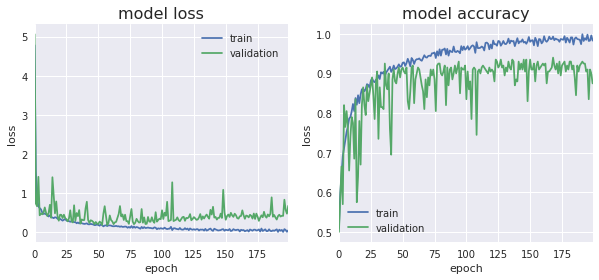

In [70]:
plot_charts(hist)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [17]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
for s_org, l_col in zip(['human', 'dog'], [human_files_short, dog_files_short]):
    print('{} images where dogs were detected: {}%'.format(s_org, sum([dog_detector(x) for x in l_col])))

human images where dogs were detected: 0%
dog images where dogs were detected: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [33]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 130.87it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
*__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.*

__Answer:__ Let's start by testing the proposed architecture

In [5]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [58]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [59]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

%time hist1 = model.fit(train_tensors, train_targets,\
                        validation_data=(valid_tensors, valid_targets),\
                        epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 196s - loss: 4.8829 - acc: 0.0100 - val_loss: 4.8683 - val_acc: 0.0108
Epoch 2/5
6680/6680 [==============================] - 196s - loss: 4.8547 - acc: 0.0126 - val_loss: 4.8512 - val_acc: 0.0108
Epoch 3/5
6680/6680 [==============================] - 196s - loss: 4.7998 - acc: 0.0190 - val_loss: 4.7997 - val_acc: 0.0192
Epoch 4/5
6680/6680 [==============================] - 197s - loss: 4.7516 - acc: 0.0207 - val_loss: 4.7640 - val_acc: 0.0228
Epoch 5/5
6680/6680 [==============================] - 197s - loss: 4.7138 - acc: 0.0259 - val_loss: 4.7373 - val_acc: 0.0251
CPU times: user 51min 5s, sys: 7min 41s, total: 58min 47s
Wall time: 16min 24s


### Load the Model with the Best Validation Loss

In [91]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [92]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.8708%


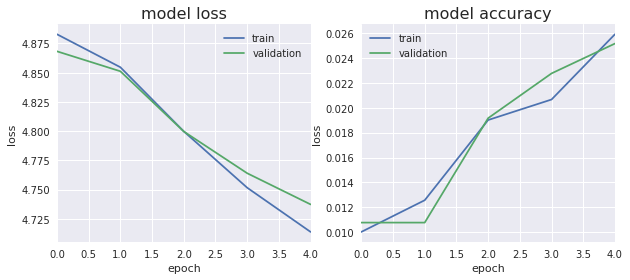

In [71]:
plot_charts(hist1)

The initial architecture was able to achieve an accuracy of 2.87% in the test set. The model loss behavior suggests that there is a lot to improve yet. So, first, let's try to do that using data augmentation. We are going to use the same architecture, with the same number of epochs and batch size, but augmenting the training data.

In [34]:
# lets try using the same architecture with training data augmented

from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
# datagen_valid = ImageDataGenerator(
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)
# datagen_valid.fit(valid_tensors)

In [48]:
model = Sequential()

### TODO: Define your architecture.

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 64)                0         
__________

In [49]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
epochs = 5
batch_size = 20


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch2a.hdf5', 
                               verbose=1, save_best_only=True)


%time hist2 = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),\
                                  steps_per_epoch=train_tensors.shape[0] // batch_size,\
                                  epochs=epochs, verbose=2, callbacks=[checkpointer],\
                                  validation_data=(valid_tensors, valid_targets),\
                                  validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/5
Epoch 00000: val_loss improved from inf to 4.86663, saving model to saved_models/weights.best.from_scratch2a.hdf5
216s - loss: 4.8838 - acc: 0.0094 - val_loss: 4.8666 - val_acc: 0.0108
Epoch 2/5
Epoch 00001: val_loss improved from 4.86663 to 4.84085, saving model to saved_models/weights.best.from_scratch2a.hdf5
217s - loss: 4.8507 - acc: 0.0157 - val_loss: 4.8408 - val_acc: 0.0204
Epoch 3/5
Epoch 00002: val_loss improved from 4.84085 to 4.81080, saving model to saved_models/weights.best.from_scratch2a.hdf5
215s - loss: 4.8064 - acc: 0.0151 - val_loss: 4.8108 - val_acc: 0.0180
Epoch 4/5
Epoch 00003: val_loss improved from 4.81080 to 4.78902, saving model to saved_models/weights.best.from_scratch2a.hdf5
212s - loss: 4.7692 - acc: 0.0195 - val_loss: 4.7890 - val_acc: 0.0168
Epoch 5/5
Epoch 00004: val_loss improved from 4.78902 to 4.75897, saving model to saved_models/weights.best.from_scratch2a.hdf5
211s - loss: 4.7399 - acc: 0.0254 - val_loss: 4.7590 - val_acc: 0.0204
CPU times

In [51]:
model.load_weights('saved_models/weights.best.from_scratch2a.hdf5')

In [52]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.8278%


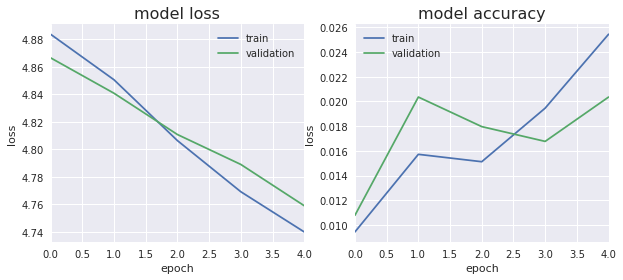

In [55]:
plot_charts(hist2)

Using augmented data with the same architecture improved the model accuracy from 2.8% to 3.8%. Now, let's try a structure similar to that I used in the first step of this project, two fully connected layers after the global average pooling layer and a dropout layer between them. I will also increase the number of filters in the convolutional layers and their kernel sizes. As the model loss curve is descending in the validation and test sets in the previous model, I will also increase the number of epochs to train this architecture.

In [90]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(8, 8), padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=1))
model.add(GlobalAveragePooling2D())
model.add(Dense(665, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 224, 224, 32)      6176      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 112, 112, 64)      32832     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
global_average_pooling2d_16  (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 665)               43225     
_________________________________________________________________
dropout_4 (Dropout)          (None, 665)               0         
__________

In [91]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
epochs = 10
batch_size = 20


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch3a.hdf5', 
                               verbose=1, save_best_only=True)


%time hist3 = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),\
                                  steps_per_epoch=train_tensors.shape[0] // batch_size,\
                                  epochs=epochs, verbose=1, callbacks=[checkpointer],\
                                  validation_data=(valid_tensors, valid_targets),\
                                  validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/10
334/334 [==============================] - 1273s - loss: 4.8852 - acc: 0.0090 - val_loss: 4.8699 - val_acc: 0.0084
Epoch 2/10
334/334 [==============================] - 1274s - loss: 4.8739 - acc: 0.0108 - val_loss: 4.8632 - val_acc: 0.0108
Epoch 3/10
334/334 [==============================] - 1287s - loss: 4.8445 - acc: 0.0148 - val_loss: 4.7993 - val_acc: 0.0168
Epoch 4/10
334/334 [==============================] - 1275s - loss: 4.7649 - acc: 0.0190 - val_loss: 4.7116 - val_acc: 0.0287
Epoch 5/10
334/334 [==============================] - 1267s - loss: 4.6912 - acc: 0.0244 - val_loss: 4.6465 - val_acc: 0.0323
Epoch 6/10
334/334 [==============================] - 1268s - loss: 4.6345 - acc: 0.0262 - val_loss: 4.6399 - val_acc: 0.0407
Epoch 7/10
334/334 [==============================] - 1268s - loss: 4.5896 - acc: 0.0328 - val_loss: 4.5839 - val_acc: 0.0323
Epoch 8/10
334/334 [==============================] - 1268s - loss: 4.5424 - acc: 0.0373 - val_loss: 4.5623 - val_acc:

In [93]:
model.load_weights('saved_models/weights.best.from_scratch3a.hdf5')

In [94]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.7847%


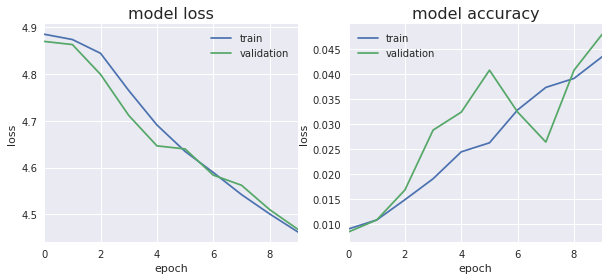

In [77]:
plot_charts(hist3)

The accuracy of the final model on the test set was 4.78%. As the model loss curves are still descending, it is difficult to say how much the structure chosen contributed to the improvement on the accuracy. It might be related just to the increment in the training time.

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [11]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [14]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [15]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

%time hist4 = VGG16_model.fit(train_VGG16, train_targets, \
                              validation_data=(valid_VGG16, valid_targets), \
                              epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 7.9593 - acc: 0.5015 - val_loss: 8.6538 - val_acc: 0.4048
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 7.9485 - acc: 0.5025 - val_loss: 8.6763 - val_acc: 0.4144
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 7.8993 - acc: 0.5048 - val_loss: 8.6120 - val_acc: 0.4096
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 7.7575 - acc: 0.5096 - val_loss: 8.4546 - val_acc: 0.4096
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 7.6137 - acc: 0.5157 - val_loss: 8.2957 - val_acc: 0.4275
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 7.4986 - acc: 0.5231 - val_loss: 8.3325 - val_acc: 0.4108
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 7.2867 - acc: 0.5311 - val_loss: 8.0810 - val_acc: 0.4228
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 7.1228 - ac

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [25]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.1292%


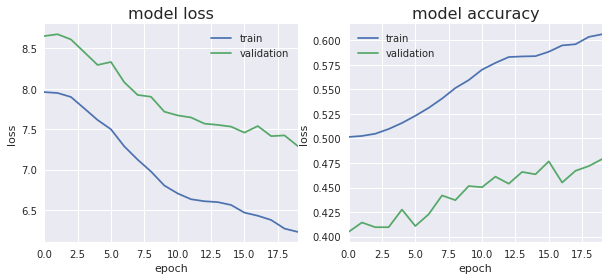

In [26]:
plot_charts(hist4)

### Predict Dog Breed with the Model

In [27]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [78]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
l_networks = [ 'VGG19', 'Resnet50', 'InceptionV3', 'Xception']
data = {x : {'train': 0, 'valid': 0, 'test': 0} for x in l_networks}
for network in l_networks:
    bottleneck_features = np.load('bottleneck_features/Dog{}Data.npz'.format(network))
    data[network]['train'] = bottleneck_features['train']
    data[network]['valid'] = bottleneck_features['valid']
    data[network]['test'] = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
*__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.*

__Answer:__ To chose the final architecture, let's start checking the performance of the different models on the validation set. Note that I will hold the test set for the last evaluation, so I will not select the structure based on a dataset that should be unseen by the model.



In [88]:
def train_model(s_network, data):
    print('testing the {} model\n===================='.format(s_network))
    model_aux = Sequential()
    model_aux.add(GlobalAveragePooling2D(input_shape=data[s_network]['train'].shape[1:]))
    model_aux.add(Dense(133, activation='softmax'))
    
    model_aux.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.{}_1.hdf5'.format(s_network), 
                                   verbose=1, save_best_only=True)

    hist_aux = model_aux.fit(data[s_network]['train'], train_targets, \
                             validation_data=(data[s_network]['valid'], valid_targets), \
                             epochs=20, batch_size=20, callbacks=[checkpointer], verbose=0)
    
    model_aux.load_weights('saved_models/weights.best.{}_1.hdf5'.format(s_network))
    
    # get index of predicted dog breed for each image in test set
    model_predictions = [np.argmax(model_aux.predict(np.expand_dims(feature, axis=0)))
                         for feature in data[s_network]['valid']]

    # report validation accuracy
    f_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(valid_targets, axis=1))/len(model_predictions)
    print('Validation accuracy: %.4f%%' % f_accuracy)
    
    return hist_aux

In [89]:
d_hist = {}
for network in l_networks:
    %time d_hist[network] = train_model(network, data)
    print('\n\n')

testing the VGG19 model
Epoch 00000: val_loss improved from inf to 9.87646, saving model to saved_models/weights.best.VGG19_1.hdf5
Epoch 00001: val_loss improved from 9.87646 to 9.22512, saving model to saved_models/weights.best.VGG19_1.hdf5
Epoch 00002: val_loss improved from 9.22512 to 8.95780, saving model to saved_models/weights.best.VGG19_1.hdf5
Epoch 00003: val_loss improved from 8.95780 to 8.80565, saving model to saved_models/weights.best.VGG19_1.hdf5
Epoch 00004: val_loss improved from 8.80565 to 8.79467, saving model to saved_models/weights.best.VGG19_1.hdf5
Epoch 00005: val_loss improved from 8.79467 to 8.66512, saving model to saved_models/weights.best.VGG19_1.hdf5
Epoch 00006: val_loss improved from 8.66512 to 8.56227, saving model to saved_models/weights.best.VGG19_1.hdf5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 8.56227 to 8.51844, saving model to saved_models/weights.best.VGG19_1.hdf5
Epoch 00009: val_loss improved from 8.51844 to 8.47017

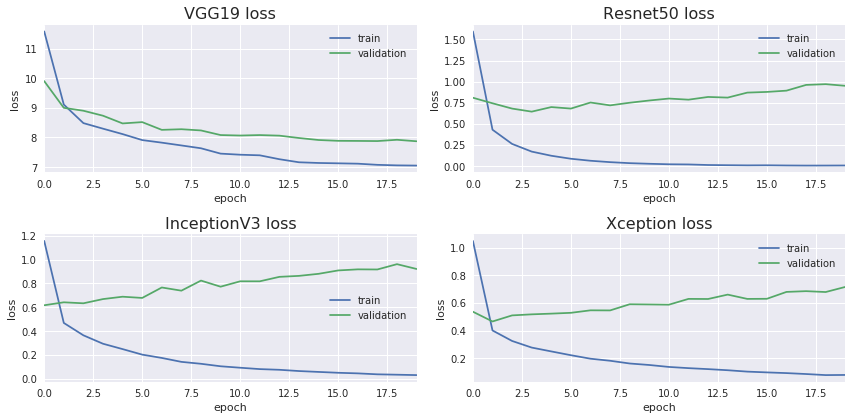

In [63]:
f, na_ax = plt.subplots(2, 2, figsize=(12, 6))
for s_key, ax in zip(d_hist.keys(), na_ax.flatten()):
    pd.Series(d_hist[s_key].history['loss']).plot(label='train', legend=True, ax=ax)
    pd.Series(d_hist[s_key].history['val_loss']).plot(label='validation', legend=True, ax=ax)
    ax.set_title('{} loss'.format(s_key), fontsize=16)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
f.tight_layout()

The only model that continuously improved throughout the training was the `VGG19` network. However, it has also presented the worst accuracy in the validation set. The other models have stopped improving at the beginning of the training loop, around the 2~3 epoch. The loss chart of each model suggests that there is not much to improve them using a simple additional architecture, as I tested (a global average pooling layer followed by the output full connected layer). 

As the Xception model achieved the best validation accuracy, I am going to use this model in the next steps. Let's see if we can improve it trying different combinations of an additional full connected layer using different activation functions, a dropout layer, and different batch sizes.

In [65]:
from keras import regularizers

def grid_search_DL(data, s_id, nodes=None, dropout=None, activation=None, batch_size=10):
    s_network = 'Xception'
    s_msg = 'test {}: dropout={}, batch_size={}'.format(s_id, dropout, batch_size)
    if nodes:
        s_msg += ', additional layer=(nodes={}, activation={})'.format(nodes, activation)
    s_msg += '\n===================='
    print(s_msg)
    model_aux = Sequential()
    model_aux.add(GlobalAveragePooling2D(input_shape=data[s_network]['train'].shape[1:]))
    if activation:
        model_aux.add(Dense(nodes, activation=activation))
    if dropout:
        model_aux.add(Dropout(dropout))
    model_aux.add(Dense(133, activation='softmax'))
    
    model_aux.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.{}_{}.hdf5'.format(s_network, s_id), 
                                   verbose=1, save_best_only=True)

    hist_aux = model_aux.fit(data[s_network]['train'], train_targets, \
                             validation_data=(data[s_network]['valid'], valid_targets), \
                             epochs=6, batch_size=batch_size, callbacks=[checkpointer], verbose=0)
    
    model_aux.load_weights('saved_models/weights.best.{}_{}.hdf5'.format(s_network, s_id))
    
    # get index of predicted dog breed for each image in test set
    model_predictions = [np.argmax(model_aux.predict(np.expand_dims(feature, axis=0)))
                         for feature in data[s_network]['valid']]

    # report validation accuracy
    f_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(valid_targets, axis=1))/len(model_predictions)
    print('Validation accuracy: %.4f%%' % f_accuracy)
    
    return hist_aux

In [67]:
d_hist2 = {}
i_id = 1
for batch_size in [20, 40, 60]:
    for dropout in [None, 0.2, 0.4]:
        for add_layer in [False, True]:
            if add_layer:
                for activation in ['relu', 'tanh']:
                    for nodes in [400, 500]: 
                        s_id = '{:02d}'.format(i_id)
                        %time d_hist2[s_id] = grid_search_DL(data,s_id, nodes=nodes, dropout=dropout,\
                                                              activation=activation,\
                                                              batch_size=batch_size)
                        i_id += 1
                        print('\n')
            else:
                s_id = '{:02d}'.format(i_id)
                %time d_hist2[s_id] = grid_search_DL(data, s_id, nodes=None, dropout=dropout,\
                                                        activation=None, batch_size=batch_size)
                i_id += 1
                print('\n')

test 01: dropout=None, batch_size=20
Epoch 00000: val_loss improved from inf to 0.52196, saving model to saved_models/weights.best.Xception_01.hdf5
Epoch 00001: val_loss improved from 0.52196 to 0.49386, saving model to saved_models/weights.best.Xception_01.hdf5
Epoch 00002: val_loss improved from 0.49386 to 0.47992, saving model to saved_models/weights.best.Xception_01.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Validation accuracy: 85.0299%
CPU times: user 31.4 s, sys: 2.58 s, total: 34 s
Wall time: 17 s


test 02: dropout=None, batch_size=20, additional layer=(nodes=400, activation=relu)
Epoch 00000: val_loss improved from inf to 0.64248, saving model to saved_models/weights.best.Xception_02.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Validation accuracy: 80.00

All the 45 architectures tested achieved accuracy between 80~85%. Something that has caught my attention is that the more sophisticated structures tested, that includes an additional full connected layer and a dropout layer, did not perform very well when compared to the simple ones. Let's check that, statistically. First, let's wrangle the data generated above. The output was saved in a file called `output.txt`:

In [6]:
import pandas as pd

d_test = {}
with open('output.txt', 'r') as fr:
    for row in fr:
        if 'test ' in row:
            a, b = row.strip().split(':')
            d_test[a] = {}
            d_test[a]['add_layer'] = False
            d_test[a]['nodes'] = None
            d_test[a]['activation'] = None
            if 'additional layer='in row:
                d_test[a]['nodes'] = int(row.split('nodes=')[1].split(',')[0])
                d_test[a]['activation'] = row.split('activation=')[1].split(')')[0]
                d_test[a]['add_layer'] = True
            d_test[a]['dropout'] = row.split('dropout=')[1].split(',')[0]
            d_test[a]['batch_size'] = int(row.split('batch_size=')[1].split(',')[0])
            i_count = 0
        elif 'val_loss improved' in row:
            i_count += 1
        elif 'Validation accuracy: ' in row:
            d_test[a]['accuracy'] = float(row.split('Validation accuracy: ')[1].split('%')[0])/100

df_results = pd.DataFrame(d_test).T

Now, let's comapare the accuracy of the models that included and that did not include the additional layer. I will perform a a one-sided Welch's unequal variances t-test for the null hypothesis that model using an additional layer have better accuracy than the models that did not use. As the implementation of the t-test in the scipy assumes a two-sided t-test, to perform the one-sided test, we will divide the p-value by 2 to compare to a critical value of 0.05 and requires that the t-value is greater than zero. 

In [46]:
import pandas as pd
import scipy
#performs t-test
add_layer = df_results[df_results.add_layer].accuracy.values
no_add_layer = df_results[[not x for x in df_results.add_layer]].accuracy.values
tval, p_value = scipy.stats.ttest_ind(add_layer, no_add_layer, equal_var=False)
print("t-value = {:0.6f}, p-value = {:0.8f}".format(tval, p_value/2))

t-value = -8.460677, p-value = 0.00000000


As we can see, using more complex architectures resulted in models with significantly WORSE (`t-value < 0`) accuracies. Now, let's check the performance of the models that did not include the additional layer.

In [43]:
df_results[[not x for x in df_results.add_layer]]

,accuracy,activation,add_layer,batch_size,dropout,nodes
test 01,0.850299,None,False,20,None,None
test 06,0.861078,None,False,20,0.2,None
test 11,0.847904,None,False,20,0.4,None
test 16,0.857485,None,False,40,None,None
test 21,0.861078,None,False,40,0.2,None
test 26,0.85509,None,False,40,0.4,None
test 31,0.865868,None,False,60,None,None
test 36,0.853892,None,False,60,0.2,None
test 41,0.85988,None,False,60,0.4,None


As the higher accuracy was achieved by a model that just used a batch size of $60$, I will use as my final model the Xception network with a global average pooling layer and a fully connected layer and I am going to use $60$ epochs to train the model.

In [18]:
### TODO: Define your architecture.
s_network = 'Xception'
final_model = Sequential()
final_model.add(GlobalAveragePooling2D(input_shape=data[s_network]['train'].shape[1:]))
final_model.add(Dense(133, activation='softmax'))

final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [19]:
### TODO: Compile the model.
final_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [16]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.{}_{}.hdf5'.format(s_network, 'final'), 
                               verbose=1, save_best_only=True)

%time hist_final = final_model.fit(data[s_network]['train'], train_targets, \
                                   validation_data=(data[s_network]['valid'], valid_targets), \
                                   epochs=20, batch_size=60, callbacks=[checkpointer], verbose=0)

Epoch 00000: val_loss improved from inf to 0.57763, saving model to saved_models/weights.best.Xception_final.hdf5
Epoch 00001: val_loss improved from 0.57763 to 0.47172, saving model to saved_models/weights.best.Xception_final.hdf5
Epoch 00002: val_loss improved from 0.47172 to 0.44022, saving model to saved_models/weights.best.Xception_final.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss did not improve
Epoch 00019: val_loss did not improve
CPU 

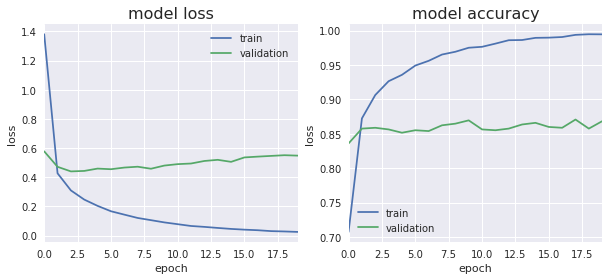

In [17]:
plot_charts(hist_final)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [20]:
### TODO: Load the model weights with the best validation loss.
final_model.load_weights('saved_models/weights.best.{}_{}.hdf5'.format(s_network, 'final'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [21]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
model_predictions = [np.argmax(final_model.predict(np.expand_dims(feature, axis=0)))
                     for feature in data[s_network]['test']]

# report test accuracy
test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.4498%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [22]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import extract_Xception

def predict_dog_breed(s_path, model):
    '''
    Return the dog breed predicted by the model passed
    
    :param s_path: string. The path to the image to be analyzed
    :param model: Keras Model. The model to use in the prediction
    '''
    tensor = path_to_tensor(s_path)
    bottleneck_feature = extract_Xception(tensor)
    idx = np.argmax(model.predict(bottleneck_feature))
    return dog_names[idx]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [23]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
class WhatIsItError(Exception):
    '''
    Raise by breed_dection when the functions is not able to detect if the image
    passed is a dog or a human
    '''
    pass

def breed_detection(img_path, model):
    '''
    Return the predict the likely dog breed in the image passed, if it is
    from a dog or a human face. Otherwise, raise an error
    
    :param img_path: string. The path to the image to be analyzed
    :param model: Keras Model. The model to use in the prediction
    '''
    s_msg = 'This {} looks like a ...\n{}'
    s_what_it_is = None
    # check if there is a human or a dog in the image
    if dog_detector(img_path):
        s_what_it_is = 'dog'
    elif face_detector(img_path):
        s_what_it_is = 'human'
    # raise an eeror it it not able to identify
    if not s_what_it_is:
        s_err = 'It was not possible to determine if the image passed'
        s_err += ' is a dog or a human'
        raise WhatIsItError(s_err)
    # predic the likely breed of the image
    s_breed = predict_dog_breed(img_path, model)
    return s_msg.format(s_what_it_is, s_breed)
    

In [27]:
def breed_detection_compare(img_path1, img_path2, model):
    '''
    Predict the likely dog breed in the image passed, if it is from a dog or a
    human face
    
    :param img_path: string. The path to the image to be analyzed
    :param model: Keras Model. The model to use in the prediction
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for img_path, ax in zip([img_path1, img_path2], [ax1, ax2]):
        # predic the likely breed of the image
        s_label = breed_detection(img_path, model)
    
        # convert BGR image to RGB for plotting
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # display the image, along with bounding box
        ax.imshow(cv_rgb)
        # ax1.get_xaxis().set_visible(False)
        ax.tick_params(labelbottom=False)
        ax.get_yaxis().set_visible(False)
        ax.set_xlabel(s_label, fontsize=16)
        f.tight_layout()
    plt.show()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

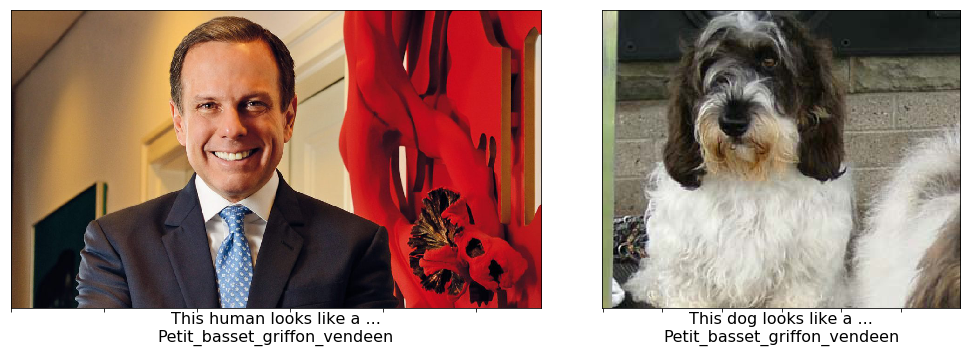

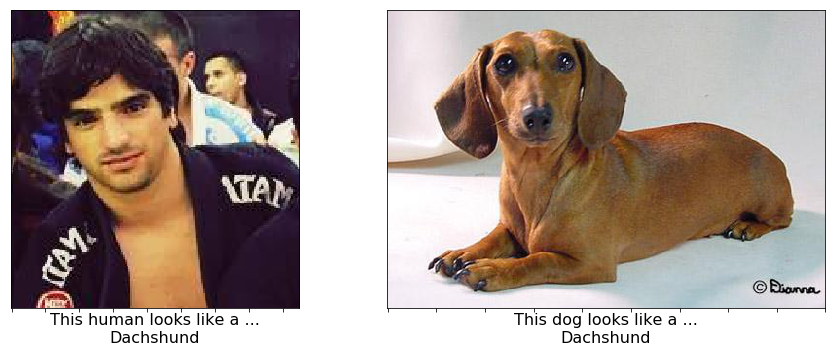

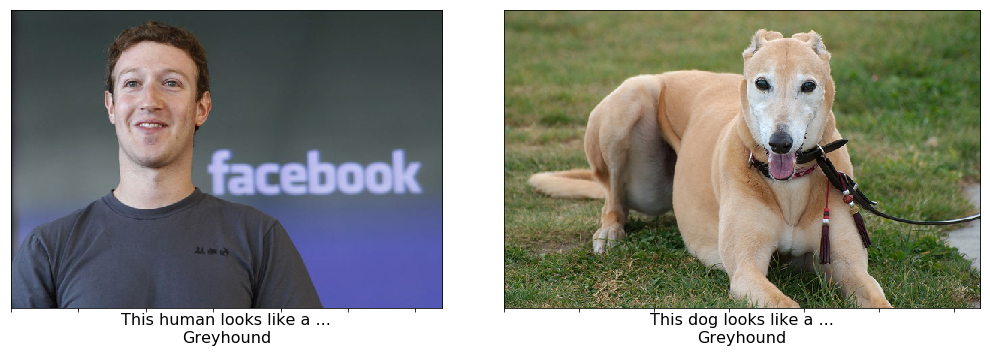

In [28]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
for s_path1, s_path2 in [('joao_doria.jpg', 'Petit_basset_griffon_vendeen_07682.jpg'),
                         ('me1.png', 'Dachshund_03992.jpg'),
                         ('Mark-zuckerberg.jpg', 'Greyhound_05545.jpg')]:
    breed_detection_compare('my_imgs/' + s_path1, 'my_imgs/' + s_path2, final_model)

I believe that the output is better than expected. The model labeled correctly the three dog images passed, and the CNN took just some seconds to be trained. The algorithm could be improved in many ways. For example, the function could predict the breed of a human based on a collection of images (I did this experiment in some of my photos, and unfortunately, it labeled me as a Dachshund in most of the examples =p ). Another possibility would be to build different models and esamble them to generate predictions. Moreover, finally, more related to usability, the function could return the closest dog breeds to a human face.